## Finding Ellipticities of CAMELS Galaxies and correlating Their Shape with Dark Matter Density.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors 
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
import h5py
import hdf5plugin
import treecorr
import time

In [2]:
def ellipticity(centre, theta, weight, x_y_or_z='z'):
    '''Calculates the ellipticity of a galaxy given its centre and positions of stellar particles
    centre - 3D position of Centre of galaxy
    theta - 3D position of stars
    x_y_or_z: from whcih axis do we want to calculate out 2D ellipticity
    weight - weighting of each star - defined as the density of space around that star'''
    xyz = {'x':[1,2], 'y':[2,0], 'z':[0,1]}
    perp_ax = xyz[x_y_or_z]
    centre = np.array([centre[perp_ax[0]], centre[perp_ax[1]]]).T       # 2D
    theta = np.array([theta[:,perp_ax[0]], theta[:,perp_ax[1]]]).T        # 2D
    separation = (theta - centre) %25 #calculating separations of members from cluster centre
    for i in range(separation.shape[0]):
        for j in range(2):  # Iterate over x, y, and z components
            if separation[i, j] < -10:
                separation[i, j] += 25
            elif separation[i, j] > 10:
                separation[i, j] -= 25
    prob = weight/np.max(weight)
    prob = np.array([prob,prob]).T # multiply x and y coord
    separation_scaled = np.multiply(separation, prob)

    Q = (separation.T.dot(separation_scaled))         #'the correlation matrix'
    epsilon = (Q[0, 0] - Q[1, 1] + 2j*Q[0,1])/(Q[0, 0] + Q[1,1] + 2*np.sqrt(np.linalg.det(Q)))				#epsilon

    return epsilon

In [6]:
filenum = 643
# Importing snapshot and catalogue data at redshift z=0
snapshot = f'C:\CAMELS DATA\LH{filenum}_snap_033IllustrisTNG.hdf5' # snapshot name
# open the snapshot
f = h5py.File(snapshot, 'r')
pos_dm = f['PartType1/Coordinates'][:]/1e3  #positions of dark matter in Mpc/h
pos_s = f['PartType4/Coordinates'][:]/1e3  # star positions in Mpc/h
mass_s = f['PartType4/Masses'][:]*1e10  # star masses in Mpc/h

# close file
f.close()
# catalogue name
catalogue = f'C:\CAMELS DATA\LH{filenum}_fof_subhalo_tab_033.hdf5'
# open the catalogue
f = h5py.File(catalogue, 'r')
# looking to see data in cataloge
# def print_dataset_name(name,g):
#     print(name,'&',g)
# f.visititems(print_dataset_name)
pos_sh  = f['Subhalo/SubhaloPos'][:]/1e3     #positions of SUBFIND subhalos in Mpc/h
subh_M_R_12 = f['Subhalo/SubhaloMassInRadType'][:,4]*1e10 # total stellar mass of twice the stellare alf-mass radius in Msun/h
nstar_h = f['Group/GroupLenType'][:,4]            # total number of stars in each halo
nstar_sh = f['Subhalo/SubhaloLenType'][:,4]            # total number of stars in each subhalo
n_subhalos = f['Group/GroupNsubs'][:]
# close file
f.close()

In [7]:
print('Total number of subhalos: ',np.sum(n_subhalos))
print("Total number of halos: ", len(n_subhalos))
print("Number of stars: ",len(pos_s))
print("Number of stars in halos: ",np.sum(nstar_h))
print("Number of stars in subhalos: ",np.sum(nstar_sh))

Total number of subhalos:  17157
Total number of halos:  18326
Number of stars:  1662042
Number of stars in halos:  1656026
Number of stars in subhalos:  1653397


In [5]:
print(start,stop)

NameError: name 'start' is not defined

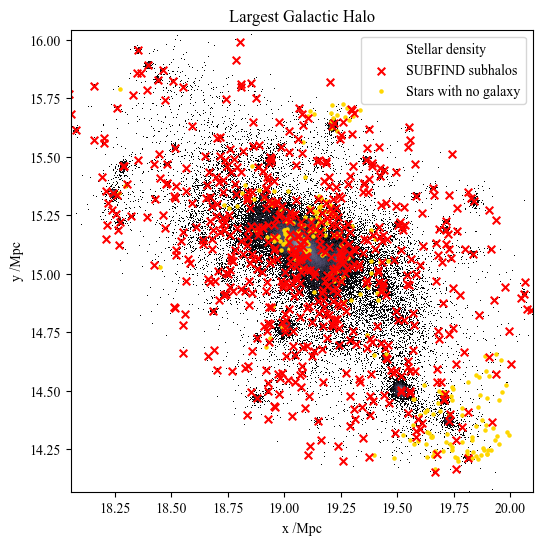

In [8]:
s_first_h = nstar_h[0] # number of stars in first halo
stop = s_first_h
s = n_subhalos[0] # number of subhalos in first halo
start = np.sum(nstar_sh[:s])
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
hist = ax.hist2d(pos_s[:stop, 1], pos_s[:stop, 0], cmap='bone', norm=colors.LogNorm(), bins=500)
sc1 = ax.scatter(pos_s[start:stop, 1], pos_s[start:stop, 0], marker='o', s=5, alpha=1.0, c='gold', label='Stars with no galaxy')
sc2 = ax.scatter(pos_sh[:s, 1], pos_sh[:s, 0], marker='x', s=30, alpha=1, c='r', label='SUBFIND subhalos')
ax.set_xlabel('x /Mpc')
ax.set_ylabel('y /Mpc')
ax.set_title('Largest Galactic Halo')
ax.set_box_aspect(1)

# Create a dummy artist for the hist2d plot to add it to the legend
dummy_artist = plt.Line2D([], [], linestyle='-', linewidth=1, color='white', label='Stellar density')
# Combine scatter plots and the dummy artist in the legend
handles = [dummy_artist, sc2, sc1]
labels = [handle.get_label() for handle in handles]
ax.legend(handles=handles, labels=labels)

plt.show()

#### Assigning every star to a subhalo according to SUBFIND algorithm
If a star does not belong to a subhalo but belongs to a halo, it does not get assigned an index. Stars which do not belong to any halo are at the end of the arrays thus do not get counted.

In [9]:
assigned = np.zeros(len(pos_s), dtype=bool) # Initialize an array to keep track of assigned star particles
# store the assignment of each star particle to a galaxy particle
assignment = -np.ones(len(pos_s), dtype=int)  # The index of the galaxy particle, for unassigned stars assignment =-1

begin_slice = 0
end_slice = nstar_sh[0] # end_slice - begin_silice = number of stars assigned to this subhalo w index subhalo_index
star_count = 0 # star index we are at
subhalo_index = 0   # subhalo index we are at

for i, number_sh in enumerate(n_subhalos): 
    if number_sh!=0: 
        for j in range(number_sh):          # looping through every subhalo in a halo
            
            assigned[begin_slice:end_slice] = True
            assignment[begin_slice:end_slice] = subhalo_index
            
            if nstar_sh[subhalo_index]!=0:
                begin_slice=end_slice
                end_slice = begin_slice + nstar_sh[subhalo_index+1]

            star_count += nstar_sh[subhalo_index]
            
            subhalo_index +=1

                

        old_star_count = star_count
        star_count = np.sum(nstar_h[:i+1])
        #print("unasigned stars: ", star_count - old_star_count)
        begin_slice = star_count   # skipping the stars with no subhalo
        if subhalo_index!=len(nstar_sh):
            end_slice = star_count+nstar_sh[subhalo_index]
    else:
        continue
print("It is",np.sum(n_subhalos)==subhalo_index, "we have counted all subhalos.")

It is True we have counted all subhalos.


Text(0, 0.5, 'subhalo index')

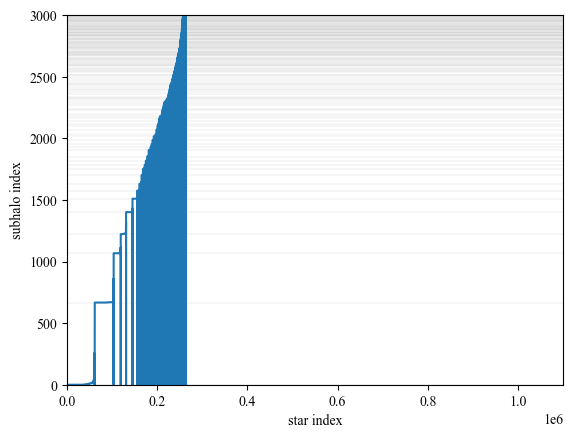

In [8]:
for __ in range(len(n_subhalos)):
    plt.axhline(np.sum(n_subhalos[:__]),c='0.5',linewidth=0.1)
plt.plot(assignment[:])
plt.xlim([0,1.1e6])
plt.ylim([0,3000])
plt.xlabel('star index')
plt.ylabel('subhalo index')

#### Galaxies are subhalos with Mstar > 1e8 Msun

In [42]:
# removing unasigned stars from star index
pos_s1 = pos_s[assigned]
mass_s1 = mass_s[assigned]
assignment1 = assignment[assigned]
# replacing subhalos with low stellar mass with np.nan
pos_g = pos_sh
pos_g[subh_M_R_12<1e8] = np.nan
pos_g2 = pos_g[~np.isnan(pos_g).any(axis=1)] # sifting 
nstar_g = nstar_sh.astype(float)
nstar_g[subh_M_R_12<1e8] = np.nan
print('Galaxy positions shape: ', pos_g.shape)

high_mass = np.where((subh_M_R_12 > 1e8) & (nstar_sh > 0))[0]
print(high_mass.shape, "galaxies")

# Create a boolean mask for the stars above the threshold mass
mask = np.isin(assignment, high_mass)

# Filter out stars in subhalos below the threshold mass
pos_s2 = pos_s[mask]
mass_s2 = mass_s[mask]
filtered_assignment1 = assignment[mask]
print("number of stars remaining:",filtered_assignment1.shape)

Galaxy positions shape:  (17157, 3)
(2061,) galaxies
number of stars remaining: (1644355,)


In [45]:
unique_values, counts = np.unique(filtered_assignment1, return_counts=True)
len(unique_values)
print(filtered_assignment1.shape)

(1644355,)


In [59]:
e_glxys = {} # dictionary for ellipticities 
for axis in ['x','y','z']:
    e_glxys[axis] = 3.0*np.ones(len(pos_g), dtype = 'complex_') # set non calaculated values to 3
assigned2 = np.zeros(len(pos_g), dtype=bool)
for axis in ['x','y','z']:
    for i in range(len(pos_g)):
        if ~np.isnan(nstar_g[i]):
            print(i,len(mass_s2[filtered_assignment1==i]), pos_s2[filtered_assignment1==i].shape,"{:.3E}".format(subh_M_R_12[i]))
            if len(mass_s2[filtered_assignment1==i])>0: # some stars are not assigned to a galaxy?
                assigned2[i]=True
                e_glxys[axis][i] = ellipticity(centre=pos_g[i], theta=pos_s2[filtered_assignment1==i],
                                               weight=mass_s2[filtered_assignment1==i], x_y_or_z=axis)
  

0 146845 (146845, 3) 8.280E+11
1 27919 (27919, 3) 1.639E+11
2 7654 (7654, 3) 4.872E+10
3 9694 (9694, 3) 6.264E+10
4 7144 (7144, 3) 5.282E+10
5 7591 (7591, 3) 5.233E+10
6 2914 (2914, 3) 1.913E+10
7 3747 (3747, 3) 2.600E+10
8 1837 (1837, 3) 1.220E+10
9 1849 (1849, 3) 1.208E+10
10 3513 (3513, 3) 2.423E+10
11 5128 (5128, 3) 4.194E+10
12 2343 (2343, 3) 1.539E+10
13 1271 (1271, 3) 8.076E+09
14 1250 (1250, 3) 8.420E+09
15 1889 (1889, 3) 1.300E+10
16 1832 (1832, 3) 1.237E+10
17 2014 (2014, 3) 1.329E+10
18 499 (499, 3) 3.677E+09
19 1280 (1280, 3) 8.804E+09
20 1546 (1546, 3) 1.093E+10
21 1137 (1137, 3) 8.152E+09
22 984 (984, 3) 6.250E+09
23 1959 (1959, 3) 1.500E+10
24 692 (692, 3) 4.795E+09
25 1410 (1410, 3) 1.022E+10
26 1089 (1089, 3) 7.568E+09
27 1324 (1324, 3) 9.138E+09
28 1588 (1588, 3) 1.156E+10
29 1351 (1351, 3) 1.005E+10
30 1484 (1484, 3) 1.052E+10
31 930 (930, 3) 6.629E+09
32 918 (918, 3) 6.637E+09
33 870 (870, 3) 6.140E+09
34 658 (658, 3) 4.409E+09
35 581 (581, 3) 3.925E+09
36 174 (174,

971 29 (29, 3) 2.466E+08
972 340 (340, 3) 2.467E+09
973 307 (307, 3) 2.274E+09
974 52 (52, 3) 4.189E+08
975 186 (186, 3) 1.274E+09
976 30 (30, 3) 2.368E+08
977 271 (271, 3) 2.023E+09
978 249 (249, 3) 1.959E+09
979 91 (91, 3) 6.746E+08
980 166 (166, 3) 1.201E+09
981 28 (28, 3) 2.192E+08
982 239 (239, 3) 1.745E+09
983 287 (287, 3) 2.116E+09
984 89 (89, 3) 7.646E+08
985 80 (80, 3) 6.979E+08
986 190 (190, 3) 1.400E+09
987 77 (77, 3) 6.297E+08
988 145 (145, 3) 1.113E+09
989 37 (37, 3) 3.175E+08
990 40 (40, 3) 2.942E+08
992 62 (62, 3) 5.024E+08
993 44 (44, 3) 3.363E+08
994 147 (147, 3) 1.140E+09
999 0 (0, 3) 1.323E+08
1000 87 (87, 3) 7.453E+08
1004 38 (38, 3) 4.097E+08
1006 0 (0, 3) 1.048E+08
1007 39 (39, 3) 3.761E+08
1008 18 (18, 3) 1.367E+08
1009 111 (111, 3) 8.124E+08
1010 13 (13, 3) 1.240E+08
1011 24 (24, 3) 2.430E+08
1012 11 (11, 3) 1.243E+08
1014 0 (0, 3) 1.413E+08
1015 30 (30, 3) 2.272E+08
1018 0 (0, 3) 1.126E+08
1021 0 (0, 3) 1.201E+08
1022 31 (31, 3) 2.650E+08
1028 27 (27, 3) 2.129E

2098 542 (542, 3) 3.986E+09
2099 283 (283, 3) 2.065E+09
2100 93 (93, 3) 7.661E+08
2101 121 (121, 3) 1.018E+09
2103 21 (21, 3) 1.654E+08
2107 120 (120, 3) 8.270E+08
2108 26 (26, 3) 2.052E+08
2119 21 (21, 3) 2.023E+08
2130 0 (0, 3) 2.271E+08
2147 16580 (16580, 3) 1.033E+11
2148 107 (107, 3) 6.974E+08
2149 293 (293, 3) 2.165E+09
2150 90 (90, 3) 7.214E+08
2151 138 (138, 3) 1.037E+09
2152 102 (102, 3) 8.229E+08
2153 50 (50, 3) 3.621E+08
2154 100 (100, 3) 6.930E+08
2155 17 (17, 3) 1.491E+08
2156 67 (67, 3) 5.417E+08
2157 21 (21, 3) 1.359E+08
2158 11 (11, 3) 1.184E+08
2180 14885 (14885, 3) 9.089E+10
2181 1715 (1715, 3) 1.105E+10
2182 613 (613, 3) 4.329E+09
2183 490 (490, 3) 3.555E+09
2184 81 (81, 3) 5.770E+08
2185 42 (42, 3) 3.639E+08
2186 40 (40, 3) 3.387E+08
2187 11 (11, 3) 1.197E+08
2195 49 (49, 3) 4.369E+08
2225 6633 (6633, 3) 4.034E+10
2226 3985 (3985, 3) 2.376E+10
2227 5743 (5743, 3) 4.099E+10
2228 131 (131, 3) 1.037E+09
2229 45 (45, 3) 4.165E+08
2230 49 (49, 3) 4.241E+08
2231 19 (19, 3

3053 82 (82, 3) 8.371E+08
3056 3000 (3000, 3) 2.008E+10
3062 1234 (1234, 3) 8.275E+09
3068 1277 (1277, 3) 8.849E+09
3069 35 (35, 3) 2.997E+08
3073 1960 (1960, 3) 1.305E+10
3076 4212 (4212, 3) 2.613E+10
3077 215 (215, 3) 1.491E+09
3082 2142 (2142, 3) 1.436E+10
3086 1522 (1522, 3) 1.003E+10
3091 1270 (1270, 3) 8.958E+09
3092 154 (154, 3) 1.311E+09
3098 1075 (1075, 3) 7.577E+09
3099 62 (62, 3) 5.031E+08
3100 12 (12, 3) 1.034E+08
3101 36 (36, 3) 3.121E+08
3106 610 (610, 3) 3.849E+09
3107 82 (82, 3) 6.327E+08
3114 1395 (1395, 3) 9.419E+09
3120 1488 (1488, 3) 9.260E+09
3123 1267 (1267, 3) 8.717E+09
3126 1726 (1726, 3) 1.152E+10
3129 1460 (1460, 3) 8.881E+09
3132 1607 (1607, 3) 1.098E+10
3133 17 (17, 3) 1.659E+08
3135 1477 (1477, 3) 1.085E+10
3138 1581 (1581, 3) 1.085E+10
3142 784 (784, 3) 5.258E+09
3143 153 (153, 3) 1.305E+09
3145 1388 (1388, 3) 9.098E+09
3146 15 (15, 3) 1.438E+08
3151 1261 (1261, 3) 8.249E+09
3152 103 (103, 3) 9.128E+08
3155 1115 (1115, 3) 7.514E+09
3164 1918 (1918, 3) 1.27

3745 215 (215, 3) 1.605E+09
3746 154 (154, 3) 1.171E+09
3747 428 (428, 3) 3.269E+09
3748 341 (341, 3) 2.247E+09
3752 1084 (1084, 3) 7.288E+09
3753 236 (236, 3) 1.687E+09
3754 279 (279, 3) 1.959E+09
3755 370 (370, 3) 2.721E+09
3756 184 (184, 3) 1.359E+09
3759 174 (174, 3) 1.196E+09
3761 400 (400, 3) 2.869E+09
3762 31 (31, 3) 2.508E+08
3763 30 (30, 3) 2.437E+08
3769 304 (304, 3) 2.440E+09
3771 180 (180, 3) 1.369E+09
3773 356 (356, 3) 2.455E+09
3774 142 (142, 3) 1.098E+09
3777 788 (788, 3) 5.065E+09
3778 171 (171, 3) 1.374E+09
3779 31 (31, 3) 2.692E+08
3780 523 (523, 3) 3.518E+09
3782 268 (268, 3) 1.959E+09
3783 555 (555, 3) 3.829E+09
3784 310 (310, 3) 2.122E+09
3785 165 (165, 3) 1.309E+09
3787 174 (174, 3) 1.477E+09
3789 177 (177, 3) 1.257E+09
3790 79 (79, 3) 5.712E+08
3795 159 (159, 3) 1.069E+09
3797 92 (92, 3) 7.160E+08
3801 161 (161, 3) 1.067E+09
3803 286 (286, 3) 2.097E+09
3804 50 (50, 3) 3.787E+08
3805 233 (233, 3) 1.831E+09
3806 178 (178, 3) 1.302E+09
3808 208 (208, 3) 1.540E+09
38

4213 52 (52, 3) 4.188E+08
4214 15 (15, 3) 1.342E+08
4217 38 (38, 3) 3.258E+08
4218 42 (42, 3) 3.664E+08
4219 19 (19, 3) 1.513E+08
4222 51 (51, 3) 4.308E+08
4224 37 (37, 3) 2.809E+08
4225 41 (41, 3) 3.683E+08
4226 34 (34, 3) 2.253E+08
4228 53 (53, 3) 4.742E+08
4229 83 (83, 3) 7.270E+08
4233 21 (21, 3) 1.433E+08
4235 360 (360, 3) 2.520E+09
4236 15 (15, 3) 1.250E+08
4238 81 (81, 3) 6.299E+08
4239 84 (84, 3) 6.154E+08
4245 28 (28, 3) 2.210E+08
4247 48 (48, 3) 4.216E+08
4249 47 (47, 3) 3.701E+08
4254 29 (29, 3) 2.525E+08
4256 31 (31, 3) 2.668E+08
4257 55 (55, 3) 4.201E+08
4258 36 (36, 3) 3.274E+08
4259 20 (20, 3) 1.454E+08
4261 33 (33, 3) 2.996E+08
4264 77 (77, 3) 6.699E+08
4265 27 (27, 3) 2.091E+08
4266 129 (129, 3) 9.417E+08
4267 73 (73, 3) 5.461E+08
4268 25 (25, 3) 1.935E+08
4271 16 (16, 3) 1.278E+08
4276 15 (15, 3) 1.573E+08
4278 41 (41, 3) 3.537E+08
4279 68 (68, 3) 4.640E+08
4282 69 (69, 3) 5.182E+08
4283 27 (27, 3) 2.389E+08
4284 54 (54, 3) 4.142E+08
4285 38 (38, 3) 2.904E+08
4287 39 

4804 16 (16, 3) 1.377E+08
4812 35 (35, 3) 2.940E+08
4815 16 (16, 3) 1.523E+08
4817 32 (32, 3) 2.726E+08
4820 15 (15, 3) 1.554E+08
4821 31 (31, 3) 2.414E+08
4823 44 (44, 3) 3.425E+08
4824 36 (36, 3) 3.363E+08
4825 15 (15, 3) 1.661E+08
4831 70 (70, 3) 6.119E+08
4832 15 (15, 3) 1.609E+08
4834 13 (13, 3) 1.125E+08
4836 23 (23, 3) 1.728E+08
4840 13 (13, 3) 1.218E+08
4841 16 (16, 3) 1.532E+08
4847 37 (37, 3) 2.919E+08
4848 35 (35, 3) 2.776E+08
4851 30 (30, 3) 2.411E+08
4852 11 (11, 3) 1.007E+08
4853 16 (16, 3) 1.254E+08
4855 18 (18, 3) 1.706E+08
4856 26 (26, 3) 2.160E+08
4864 16 (16, 3) 1.565E+08
4865 24 (24, 3) 1.972E+08
4872 13 (13, 3) 1.250E+08
4879 42 (42, 3) 3.299E+08
4887 17 (17, 3) 1.513E+08
4894 14 (14, 3) 1.234E+08
4902 41 (41, 3) 3.461E+08
4903 28 (28, 3) 2.173E+08
4904 20 (20, 3) 1.725E+08
4906 18 (18, 3) 1.686E+08
4908 38 (38, 3) 3.383E+08
4911 37 (37, 3) 2.974E+08
4913 17 (17, 3) 1.469E+08
4916 51 (51, 3) 3.689E+08
4925 39 (39, 3) 3.227E+08
4926 18 (18, 3) 1.642E+08
4930 20 (20,

98 89 (89, 3) 7.060E+08
99 43 (43, 3) 3.527E+08
101 90 (90, 3) 6.834E+08
102 90 (90, 3) 7.969E+08
104 106 (106, 3) 9.281E+08
105 35 (35, 3) 3.023E+08
106 78 (78, 3) 6.521E+08
108 158 (158, 3) 1.170E+09
109 154 (154, 3) 1.148E+09
110 95 (95, 3) 7.160E+08
111 201 (201, 3) 1.498E+09
112 90 (90, 3) 6.833E+08
113 77 (77, 3) 6.231E+08
114 23 (23, 3) 1.348E+08
115 68 (68, 3) 5.280E+08
116 16 (16, 3) 1.259E+08
117 116 (116, 3) 8.745E+08
118 34 (34, 3) 3.370E+08
119 27 (27, 3) 2.551E+08
120 112 (112, 3) 8.682E+08
121 18 (18, 3) 1.628E+08
122 60 (60, 3) 3.943E+08
123 74 (74, 3) 6.405E+08
124 130 (130, 3) 9.383E+08
125 110 (110, 3) 8.463E+08
126 117 (117, 3) 9.007E+08
127 45 (45, 3) 3.496E+08
128 93 (93, 3) 8.071E+08
129 43 (43, 3) 3.882E+08
131 13 (13, 3) 1.018E+08
132 88 (88, 3) 7.435E+08
133 72 (72, 3) 5.482E+08
134 29 (29, 3) 2.549E+08
135 38 (38, 3) 3.666E+08
136 31 (31, 3) 2.971E+08
137 11 (11, 3) 1.026E+08
138 54 (54, 3) 4.543E+08
141 118 (118, 3) 9.398E+08
143 89 (89, 3) 6.980E+08
145 102

1254 25 (25, 3) 2.243E+08
1255 82 (82, 3) 6.878E+08
1256 73 (73, 3) 6.451E+08
1258 28 (28, 3) 1.903E+08
1259 28 (28, 3) 2.788E+08
1262 129 (129, 3) 1.078E+09
1264 50 (50, 3) 4.578E+08
1265 34 (34, 3) 3.137E+08
1267 28 (28, 3) 2.025E+08
1268 84 (84, 3) 6.175E+08
1269 33 (33, 3) 3.338E+08
1274 51 (51, 3) 4.069E+08
1276 103 (103, 3) 7.099E+08
1278 69 (69, 3) 5.365E+08
1281 54 (54, 3) 4.172E+08
1283 24 (24, 3) 1.861E+08
1284 81 (81, 3) 6.159E+08
1285 20 (20, 3) 1.560E+08
1289 48 (48, 3) 4.166E+08
1291 31 (31, 3) 3.007E+08
1293 57 (57, 3) 4.642E+08
1294 19 (19, 3) 1.873E+08
1295 48 (48, 3) 3.766E+08
1300 17 (17, 3) 1.325E+08
1306 0 (0, 3) 1.102E+08
1312 10 (10, 3) 1.079E+08
1315 0 (0, 3) 1.497E+08
1324 0 (0, 3) 1.711E+08
1355 19 (19, 3) 1.802E+08
1493 61822 (61822, 3) 3.413E+11
1494 6346 (6346, 3) 4.289E+10
1495 2880 (2880, 3) 2.106E+10
1496 2621 (2621, 3) 1.799E+10
1497 1616 (1616, 3) 1.186E+10
1498 993 (993, 3) 7.372E+09
1499 607 (607, 3) 4.498E+09
1500 1207 (1207, 3) 9.937E+09
1501 152 (

2414 3613 (3613, 3) 2.245E+10
2415 1126 (1126, 3) 7.576E+09
2416 30 (30, 3) 2.307E+08
2417 23 (23, 3) 2.084E+08
2418 66 (66, 3) 5.527E+08
2419 25 (25, 3) 2.053E+08
2420 26 (26, 3) 2.452E+08
2421 11 (11, 3) 1.104E+08
2430 5875 (5875, 3) 3.806E+10
2431 120 (120, 3) 9.112E+08
2432 66 (66, 3) 5.649E+08
2433 41 (41, 3) 3.191E+08
2445 2401 (2401, 3) 1.586E+10
2446 735 (735, 3) 4.814E+09
2447 1192 (1192, 3) 7.755E+09
2448 1459 (1459, 3) 9.658E+09
2449 147 (147, 3) 1.213E+09
2450 209 (209, 3) 1.627E+09
2451 83 (83, 3) 6.874E+08
2465 0 (0, 3) 1.147E+08
2470 5865 (5865, 3) 3.442E+10
2471 2180 (2180, 3) 1.609E+10
2487 4789 (4789, 3) 2.983E+10
2488 448 (448, 3) 3.194E+09
2489 23 (23, 3) 2.296E+08
2492 0 (0, 3) 2.990E+08
2493 43 (43, 3) 3.591E+08
2507 6246 (6246, 3) 4.022E+10
2508 406 (406, 3) 2.780E+09
2509 225 (225, 3) 1.612E+09
2510 46 (46, 3) 4.028E+08
2519 6602 (6602, 3) 4.098E+10
2520 863 (863, 3) 6.201E+09
2521 23 (23, 3) 2.272E+08
2529 2538 (2538, 3) 1.629E+10
2530 1867 (1867, 3) 1.285E+10


3307 1127 (1127, 3) 7.936E+09
3311 985 (985, 3) 6.414E+09
3316 707 (707, 3) 4.597E+09
3319 1299 (1299, 3) 8.451E+09
3320 50 (50, 3) 3.860E+08
3322 905 (905, 3) 6.359E+09
3325 983 (983, 3) 7.049E+09
3327 878 (878, 3) 6.437E+09
3330 570 (570, 3) 4.153E+09
3331 131 (131, 3) 1.065E+09
3333 767 (767, 3) 5.299E+09
3336 1015 (1015, 3) 6.679E+09
3339 689 (689, 3) 4.731E+09
3343 1278 (1278, 3) 8.782E+09
3346 692 (692, 3) 4.403E+09
3347 50 (50, 3) 3.419E+08
3348 880 (880, 3) 5.576E+09
3349 839 (839, 3) 5.828E+09
3355 930 (930, 3) 6.341E+09
3358 544 (544, 3) 3.836E+09
3362 1159 (1159, 3) 7.892E+09
3363 808 (808, 3) 5.262E+09
3367 753 (753, 3) 4.917E+09
3369 290 (290, 3) 2.340E+09
3370 45 (45, 3) 3.903E+08
3372 1138 (1138, 3) 7.864E+09
3375 1093 (1093, 3) 7.044E+09
3376 12 (12, 3) 1.040E+08
3377 947 (947, 3) 6.495E+09
3379 503 (503, 3) 3.506E+09
3381 22 (22, 3) 1.803E+08
3385 708 (708, 3) 4.698E+09
3386 915 (915, 3) 6.107E+09
3388 726 (726, 3) 5.001E+09
3389 761 (761, 3) 5.166E+09
3391 1323 (1323,

3885 42 (42, 3) 3.491E+08
3886 105 (105, 3) 6.955E+08
3888 162 (162, 3) 1.223E+09
3890 192 (192, 3) 1.253E+09
3891 174 (174, 3) 1.299E+09
3892 264 (264, 3) 2.038E+09
3893 246 (246, 3) 1.672E+09
3894 109 (109, 3) 7.419E+08
3895 49 (49, 3) 3.545E+08
3897 125 (125, 3) 9.819E+08
3898 137 (137, 3) 1.076E+09
3900 159 (159, 3) 1.181E+09
3902 105 (105, 3) 7.663E+08
3904 308 (308, 3) 2.215E+09
3905 115 (115, 3) 7.599E+08
3907 128 (128, 3) 1.023E+09
3908 26 (26, 3) 2.410E+08
3910 101 (101, 3) 7.768E+08
3912 115 (115, 3) 9.493E+08
3913 26 (26, 3) 1.822E+08
3914 26 (26, 3) 2.420E+08
3916 163 (163, 3) 1.188E+09
3917 115 (115, 3) 8.979E+08
3921 52 (52, 3) 4.378E+08
3924 175 (175, 3) 1.352E+09
3925 210 (210, 3) 1.656E+09
3926 223 (223, 3) 1.702E+09
3927 131 (131, 3) 1.064E+09
3929 223 (223, 3) 1.465E+09
3930 256 (256, 3) 1.922E+09
3932 21 (21, 3) 1.687E+08
3933 105 (105, 3) 8.690E+08
3934 116 (116, 3) 9.218E+08
3935 17 (17, 3) 1.682E+08
3936 174 (174, 3) 1.221E+09
3937 212 (212, 3) 1.618E+09
3938 188

4371 17 (17, 3) 1.643E+08
4373 21 (21, 3) 1.674E+08
4376 30 (30, 3) 2.292E+08
4379 39 (39, 3) 3.267E+08
4380 70 (70, 3) 6.073E+08
4383 55 (55, 3) 4.623E+08
4384 17 (17, 3) 1.359E+08
4387 41 (41, 3) 2.956E+08
4388 39 (39, 3) 3.190E+08
4389 44 (44, 3) 3.809E+08
4393 33 (33, 3) 2.607E+08
4395 16 (16, 3) 1.331E+08
4398 53 (53, 3) 4.464E+08
4400 16 (16, 3) 1.332E+08
4402 23 (23, 3) 1.541E+08
4403 19 (19, 3) 1.519E+08
4407 77 (77, 3) 6.286E+08
4408 12 (12, 3) 1.364E+08
4410 25 (25, 3) 1.723E+08
4412 16 (16, 3) 1.078E+08
4415 35 (35, 3) 2.718E+08
4417 31 (31, 3) 2.381E+08
4418 36 (36, 3) 3.349E+08
4419 20 (20, 3) 2.017E+08
4421 38 (38, 3) 3.322E+08
4423 13 (13, 3) 1.304E+08
4426 29 (29, 3) 2.387E+08
4428 30 (30, 3) 2.123E+08
4430 16 (16, 3) 1.291E+08
4431 27 (27, 3) 2.535E+08
4432 309 (309, 3) 2.296E+09
4433 31 (31, 3) 2.510E+08
4434 27 (27, 3) 2.637E+08
4435 36 (36, 3) 2.970E+08
4436 25 (25, 3) 2.097E+08
4437 135 (135, 3) 1.035E+09
4438 39 (39, 3) 3.336E+08
4441 26 (26, 3) 1.707E+08
4444 25 

5133 14 (14, 3) 1.009E+08
5138 16 (16, 3) 1.248E+08
5143 39 (39, 3) 2.972E+08
5145 30 (30, 3) 2.106E+08
5147 0 (0, 3) 1.380E+08
5149 32 (32, 3) 2.627E+08
5155 18 (18, 3) 1.866E+08
5157 31 (31, 3) 2.340E+08
5158 10 (10, 3) 1.026E+08
5176 24 (24, 3) 2.183E+08
5179 21 (21, 3) 2.048E+08
5191 13 (13, 3) 1.364E+08
5192 16 (16, 3) 1.524E+08
5197 13 (13, 3) 1.095E+08
5199 20 (20, 3) 1.274E+08
5215 65 (65, 3) 5.009E+08
5218 14 (14, 3) 1.442E+08
5219 31 (31, 3) 2.573E+08
5220 39 (39, 3) 3.741E+08
5233 29 (29, 3) 2.538E+08
5234 66 (66, 3) 5.506E+08
5237 36 (36, 3) 3.435E+08
5238 24 (24, 3) 2.078E+08
5244 38 (38, 3) 3.263E+08
5245 18 (18, 3) 1.707E+08
5262 20 (20, 3) 1.768E+08
5265 15 (15, 3) 1.134E+08
5273 110 (110, 3) 9.053E+08
5284 12 (12, 3) 1.078E+08
5288 23 (23, 3) 2.226E+08
5290 19 (19, 3) 1.284E+08
5294 44 (44, 3) 3.718E+08
5306 41 (41, 3) 3.132E+08
5319 14 (14, 3) 1.210E+08
5329 25 (25, 3) 2.102E+08
5343 40 (40, 3) 3.667E+08
5346 60 (60, 3) 4.704E+08
5353 21 (21, 3) 1.527E+08
5372 40 (40,

618 1774 (1774, 3) 1.335E+10
619 1557 (1557, 3) 1.138E+10
620 772 (772, 3) 5.291E+09
621 921 (921, 3) 7.047E+09
622 422 (422, 3) 2.972E+09
623 825 (825, 3) 6.142E+09
624 325 (325, 3) 2.124E+09
625 524 (524, 3) 3.739E+09
626 405 (405, 3) 3.049E+09
627 652 (652, 3) 4.729E+09
628 217 (217, 3) 1.782E+09
629 101 (101, 3) 7.695E+08
630 455 (455, 3) 3.376E+09
631 163 (163, 3) 1.145E+09
632 590 (590, 3) 4.294E+09
633 514 (514, 3) 4.118E+09
634 460 (460, 3) 3.354E+09
635 44 (44, 3) 3.968E+08
636 470 (470, 3) 3.428E+09
637 176 (176, 3) 1.271E+09
638 313 (313, 3) 2.141E+09
639 393 (393, 3) 2.857E+09
640 38 (38, 3) 2.552E+08
641 75 (75, 3) 5.765E+08
642 456 (456, 3) 3.329E+09
643 224 (224, 3) 1.780E+09
644 87 (87, 3) 7.667E+08
645 255 (255, 3) 2.115E+09
646 269 (269, 3) 2.132E+09
647 162 (162, 3) 1.268E+09
648 131 (131, 3) 1.043E+09
649 287 (287, 3) 2.450E+09
650 62 (62, 3) 4.441E+08
651 30 (30, 3) 2.296E+08
652 79 (79, 3) 6.378E+08
653 54 (54, 3) 4.878E+08
654 97 (97, 3) 6.503E+08
655 186 (186, 3

1647 389 (389, 3) 3.079E+09
1648 281 (281, 3) 2.123E+09
1649 30 (30, 3) 2.328E+08
1650 198 (198, 3) 1.636E+09
1651 181 (181, 3) 1.399E+09
1652 406 (406, 3) 2.864E+09
1653 49 (49, 3) 4.114E+08
1654 133 (133, 3) 9.589E+08
1655 126 (126, 3) 9.208E+08
1656 59 (59, 3) 4.734E+08
1657 14 (14, 3) 1.561E+08
1658 45 (45, 3) 4.510E+08
1659 55 (55, 3) 4.482E+08
1660 89 (89, 3) 8.106E+08
1661 116 (116, 3) 8.719E+08
1663 174 (174, 3) 1.566E+09
1664 36 (36, 3) 2.795E+08
1665 41 (41, 3) 3.036E+08
1667 51 (51, 3) 4.932E+08
1668 144 (144, 3) 1.195E+09
1669 58 (58, 3) 5.172E+08
1670 63 (63, 3) 4.803E+08
1672 64 (64, 3) 4.891E+08
1673 120 (120, 3) 8.851E+08
1674 17 (17, 3) 1.431E+08
1677 36 (36, 3) 3.003E+08
1679 14 (14, 3) 1.426E+08
1680 51 (51, 3) 3.913E+08
1682 0 (0, 3) 2.485E+08
1683 74 (74, 3) 5.554E+08
1684 17 (17, 3) 1.638E+08
1687 19 (19, 3) 1.754E+08
1689 17 (17, 3) 1.679E+08
1704 0 (0, 3) 1.076E+08
1770 51308 (51308, 3) 3.105E+11
1771 609 (609, 3) 4.168E+09
1772 490 (490, 3) 3.563E+09
1773 221 (

2700 4180 (4180, 3) 2.817E+10
2701 292 (292, 3) 2.141E+09
2705 4904 (4904, 3) 3.068E+10
2706 33 (33, 3) 3.158E+08
2708 39 (39, 3) 3.063E+08
2718 3939 (3939, 3) 2.564E+10
2719 76 (76, 3) 6.224E+08
2726 3472 (3472, 3) 2.312E+10
2733 2471 (2471, 3) 1.594E+10
2734 153 (153, 3) 1.068E+09
2735 10 (10, 3) 1.039E+08
2743 2666 (2666, 3) 1.618E+10
2744 238 (238, 3) 1.846E+09
2745 41 (41, 3) 3.597E+08
2751 2203 (2203, 3) 1.486E+10
2752 1568 (1568, 3) 1.110E+10
2753 11 (11, 3) 1.043E+08
2757 2313 (2313, 3) 1.455E+10
2758 710 (710, 3) 5.768E+09
2759 69 (69, 3) 5.717E+08
2760 31 (31, 3) 2.987E+08
2761 12 (12, 3) 1.081E+08
2765 2978 (2978, 3) 1.963E+10
2766 25 (25, 3) 1.972E+08
2773 3039 (3039, 3) 2.006E+10
2774 64 (64, 3) 5.330E+08
2775 25 (25, 3) 2.500E+08
2780 1483 (1483, 3) 9.770E+09
2781 732 (732, 3) 4.675E+09
2794 1039 (1039, 3) 6.879E+09
2795 379 (379, 3) 2.749E+09
2796 482 (482, 3) 3.141E+09
2805 2059 (2059, 3) 1.337E+10
2806 341 (341, 3) 2.390E+09
2807 75 (75, 3) 6.470E+08
2810 747 (747, 3) 

3512 958 (958, 3) 6.456E+09
3513 870 (870, 3) 5.945E+09
3516 544 (544, 3) 3.878E+09
3517 803 (803, 3) 5.663E+09
3521 620 (620, 3) 4.355E+09
3522 631 (631, 3) 4.317E+09
3526 557 (557, 3) 3.958E+09
3527 1296 (1296, 3) 8.796E+09
3528 388 (388, 3) 2.858E+09
3532 1011 (1011, 3) 6.988E+09
3533 683 (683, 3) 4.362E+09
3535 797 (797, 3) 5.611E+09
3537 577 (577, 3) 3.985E+09
3539 732 (732, 3) 5.342E+09
3540 593 (593, 3) 4.370E+09
3541 344 (344, 3) 2.520E+09
3544 429 (429, 3) 3.164E+09
3548 237 (237, 3) 1.774E+09
3549 39 (39, 3) 3.132E+08
3551 287 (287, 3) 2.236E+09
3552 100 (100, 3) 7.695E+08
3553 360 (360, 3) 2.725E+09
3556 131 (131, 3) 9.663E+08
3557 32 (32, 3) 2.617E+08
3562 440 (440, 3) 2.967E+09
3565 355 (355, 3) 2.655E+09
3568 526 (526, 3) 3.371E+09
3569 15 (15, 3) 1.543E+08
3571 690 (690, 3) 4.698E+09
3573 245 (245, 3) 1.937E+09
3575 146 (146, 3) 1.172E+09
3577 619 (619, 3) 4.445E+09
3578 438 (438, 3) 3.105E+09
3580 160 (160, 3) 1.281E+09
3581 80 (80, 3) 6.467E+08
3586 468 (468, 3) 3.161E

4026 204 (204, 3) 1.445E+09
4027 61 (61, 3) 4.495E+08
4029 156 (156, 3) 9.074E+08
4030 62 (62, 3) 5.185E+08
4031 353 (353, 3) 2.323E+09
4036 116 (116, 3) 1.031E+09
4037 113 (113, 3) 8.255E+08
4038 233 (233, 3) 1.801E+09
4039 64 (64, 3) 5.519E+08
4040 34 (34, 3) 2.774E+08
4041 374 (374, 3) 2.842E+09
4042 61 (61, 3) 4.921E+08
4043 112 (112, 3) 7.997E+08
4045 96 (96, 3) 7.458E+08
4049 77 (77, 3) 5.604E+08
4050 93 (93, 3) 7.506E+08
4051 101 (101, 3) 6.929E+08
4052 45 (45, 3) 4.223E+08
4054 49 (49, 3) 4.275E+08
4055 180 (180, 3) 1.316E+09
4057 14 (14, 3) 1.131E+08
4058 18 (18, 3) 1.544E+08
4060 21 (21, 3) 1.770E+08
4063 110 (110, 3) 9.154E+08
4064 75 (75, 3) 6.032E+08
4066 149 (149, 3) 1.210E+09
4067 58 (58, 3) 4.222E+08
4068 91 (91, 3) 6.899E+08
4069 70 (70, 3) 5.047E+08
4070 35 (35, 3) 2.606E+08
4072 132 (132, 3) 9.637E+08
4073 45 (45, 3) 3.349E+08
4074 143 (143, 3) 1.158E+09
4075 110 (110, 3) 8.967E+08
4076 250 (250, 3) 1.834E+09
4077 85 (85, 3) 6.351E+08
4078 78 (78, 3) 5.685E+08
4079 9

4516 42 (42, 3) 3.090E+08
4517 17 (17, 3) 1.420E+08
4518 26 (26, 3) 2.276E+08
4520 37 (37, 3) 3.022E+08
4521 42 (42, 3) 2.764E+08
4522 23 (23, 3) 2.096E+08
4525 146 (146, 3) 1.241E+09
4526 32 (32, 3) 2.265E+08
4530 31 (31, 3) 2.839E+08
4534 19 (19, 3) 1.465E+08
4536 27 (27, 3) 2.256E+08
4537 39 (39, 3) 3.124E+08
4539 11 (11, 3) 1.202E+08
4540 13 (13, 3) 1.081E+08
4541 15 (15, 3) 1.123E+08
4542 11 (11, 3) 1.035E+08
4545 247 (247, 3) 2.007E+09
4546 172 (172, 3) 1.243E+09
4547 22 (22, 3) 2.145E+08
4549 41 (41, 3) 3.458E+08
4550 224 (224, 3) 1.603E+09
4551 43 (43, 3) 3.243E+08
4555 28 (28, 3) 1.969E+08
4556 20 (20, 3) 1.579E+08
4557 19 (19, 3) 1.709E+08
4559 16 (16, 3) 1.244E+08
4560 38 (38, 3) 3.363E+08
4561 22 (22, 3) 2.244E+08
4566 31 (31, 3) 2.676E+08
4567 52 (52, 3) 3.910E+08
4571 20 (20, 3) 1.486E+08
4572 111 (111, 3) 8.974E+08
4573 23 (23, 3) 2.192E+08
4574 23 (23, 3) 2.227E+08
4579 32 (32, 3) 2.655E+08
4580 30 (30, 3) 2.109E+08
4582 15 (15, 3) 1.099E+08
4585 18 (18, 3) 1.649E+08
45

6278 12 (12, 3) 1.412E+08
6285 21 (21, 3) 1.836E+08
6299 30 (30, 3) 2.693E+08
6303 37 (37, 3) 3.540E+08
6330 20 (20, 3) 1.977E+08
6346 26 (26, 3) 2.081E+08
6471 20 (20, 3) 1.509E+08
6478 13 (13, 3) 1.131E+08
6517 13 (13, 3) 1.009E+08
6571 24 (24, 3) 2.172E+08
6646 10 (10, 3) 1.002E+08
6649 25 (25, 3) 2.324E+08
6678 16 (16, 3) 1.320E+08
6695 29 (29, 3) 2.229E+08
6712 12 (12, 3) 1.073E+08
6732 22 (22, 3) 1.899E+08
6821 15 (15, 3) 1.448E+08
6855 25 (25, 3) 2.022E+08
6894 15 (15, 3) 1.467E+08
6896 16 (16, 3) 1.443E+08
6970 31 (31, 3) 2.530E+08
7072 12 (12, 3) 1.083E+08
7234 14 (14, 3) 1.071E+08
7249 29 (29, 3) 2.843E+08
7284 15 (15, 3) 1.500E+08
7290 28 (28, 3) 2.126E+08
7308 9 (9, 3) 1.011E+08
7549 21 (21, 3) 1.855E+08
7565 13 (13, 3) 1.063E+08
7869 32 (32, 3) 2.661E+08
7883 14 (14, 3) 1.088E+08
8036 21 (21, 3) 1.929E+08
8138 11 (11, 3) 1.111E+08
8388 18 (18, 3) 1.672E+08
8456 13 (13, 3) 1.404E+08
10036 14 (14, 3) 1.296E+08


In [61]:
for axis, ell_array in e_glxys.items():
    e_glxys[axis] = ell_array[ell_array!=3]
    print(f"Old Shape of angles and ratios for axis '{axis}': {e_glxys[axis].shape}")

pos_g3 = pos_g[assigned2]
print(pos_g3.shape)

Old Shape of angles and ratios for axis 'x': (2024,)
Old Shape of angles and ratios for axis 'y': (2024,)
Old Shape of angles and ratios for axis 'z': (2024,)
(2024, 3)


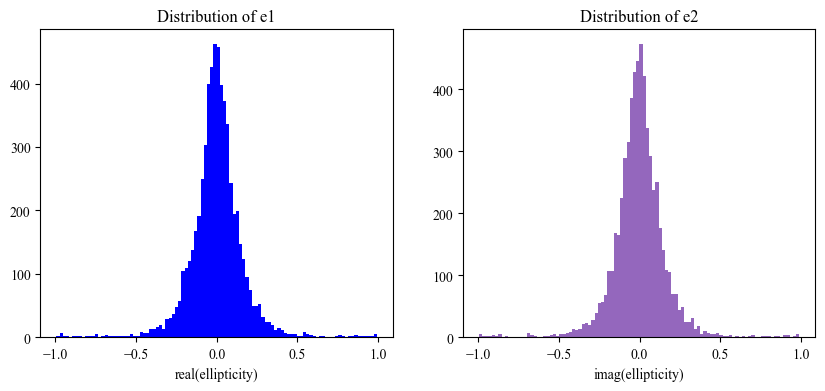

In [53]:
all_e = np.concatenate([e_array for e_array in e_glxys.values()]) # distributions of ellipticities
fig, ax = plt.subplots(1, 2,figsize=(10, 4))
ax[0].hist(all_e.real,bins=100,label='e1',color='blue')
ax[0].set_title('Distribution of e1')
ax[0].set_xlabel('real(ellipticity)')
ax[1].hist(all_e.imag,bins=100,label='e2',color='tab:purple')
ax[1].set_title('Distribution of e2')
ax[1].set_xlabel('imag(ellipticity)')
plt.show()

In [54]:
def stick_plot(ax, x, y, ellipticity, phi, bar_scaling=1, plot_index=None):
    '''Imput the positions of galaxies, magnitudee of the complex ellipticity '''
    ellipticity = ellipticity  * bar_scaling # making more elliptical galaxies loger bars
    del_y = ellipticity*np.sin(phi)
    del_x = ellipticity*np.cos(phi)
    # positions of ends of bar
    barx = np.array([x+del_x,x-del_x])
    bary = np.array([y+del_y,y-del_y])
    bars = np.array([barx,bary])
    
    #fig, ax = plt.subplots(figsize=(6,6))
    for i in range(len(ellipticity)):
        ax.plot(bars[0,:,i],bars[1,:,i],color='#EF2E72') 
        #ax.set_xticks([])
        #ax.set_yticks([])
        #ax.set_title('Showing Ellipticities of Galaxies')
        ax.set_box_aspect(1)

average q value of elliptical galaxies in x axis:  (-0.005595833084094224-0.0026602405862760034j)
average q value of elliptical galaxies in y axis:  (0.003288078798930138+0.002278476087892624j)
average q value of elliptical galaxies in z axis:  (0.001678193488240602-0.0065874699489897525j)


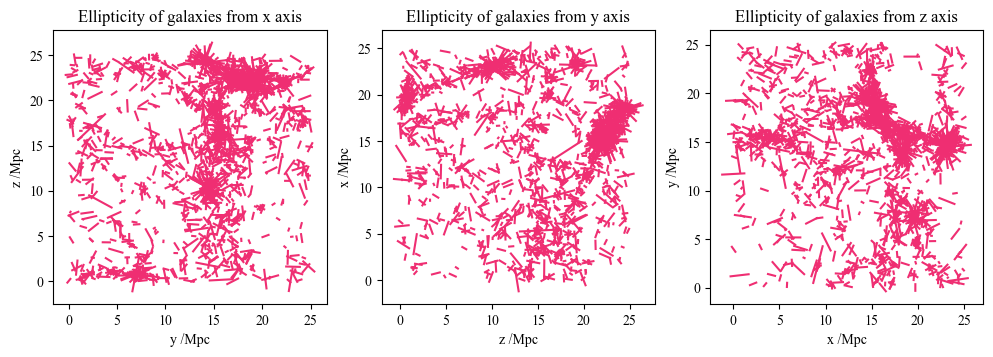

In [57]:
xyz = [['x',1,2],['y',2,0],['z',0,1]]
fig, ax = plt.subplots(1, 3,figsize=(12, 4))
for x_y_or_z in range(3):
    _ax_ = xyz[x_y_or_z][0] # which axis is perpendicular to the slice
    h = xyz[x_y_or_z][1] # horizontal axis
    v = xyz[x_y_or_z][2] # vertical axis

    #ax = fig.add_subplot(1,3,x_y_or_z+1)
    ax[x_y_or_z].set_xlabel(f'{xyz[h][0]} /Mpc')
    ax[x_y_or_z].set_ylabel(f'{xyz[v][0]} /Mpc')
    ax[x_y_or_z].set_title(f"Ellipticity of galaxies from {_ax_} axis")
    stick_plot(ax[x_y_or_z], pos_g3[:,h], pos_g3[:,v], np.absolute(e_glxys[_ax_]), np.angle(e_glxys[_ax_])/2, bar_scaling=2)
    print(f"average q value of elliptical galaxies in {_ax_} axis: ", np.mean(e_glxys[_ax_]))
plt.show()